In [9]:
import pandas as pd

input_file = "./archive/flickr30k_images/results.csv"
output_file = "./archive/flickr30k_images/results_cleaned.csv"

# Try flexible parsing and skip bad lines
data = pd.read_csv(
    input_file,
    sep='|',
    engine='python',
    skipinitialspace=True,
    on_bad_lines='skip',   # ✅ skip malformed lines
    quoting=3              # ✅ disable quote handling issues
)

# Remove unwanted spaces
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Fix column names if needed
data.columns = ['image_name', 'comment_number', 'comment'][:len(data.columns)]

# Drop rows missing important values
data.dropna(subset=['image_name', 'comment'], inplace=True)

# Remove duplicates
data.drop_duplicates(inplace=True)

# Save cleaned file
data.to_csv(output_file, index=False)
print("✅ Cleaned CSV saved as:", output_file)


✅ Cleaned CSV saved as: ./archive/flickr30k_images/results_cleaned.csv


AttributeError: 'DataFrame' object has no attribute 'image'

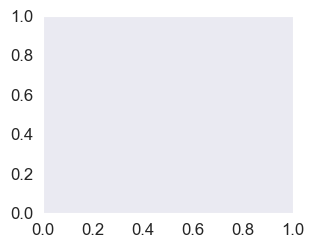

In [10]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Embedding, Dropout, 
                                    concatenate, Reshape, add, GlobalAveragePooling2D)
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import warnings

# Set visualization parameters
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# 1. Data Loading and Preprocessing
# =================================

# Define image path and load captions
image_path = './archive/flickr30k_images'
data = pd.read_csv("./archive/flickr30k_images/results_cleaned.csv", sep=None, engine='python')

# Function to read and preprocess images
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0  # Normalize to [0,1]
    return img

# Function to display images with captions
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# Display sample images with captions
display_images(data.sample(15))

# Text preprocessing function
def text_preprocessing(data):
    # Convert to lowercase
    data['caption'] = data['caption'].str.lower()
    # Remove non-alphabet characters
    data['caption'] = data['caption'].str.replace("[^A-Za-z]", "", regex=True)
    # Remove extra spaces
    data['caption'] = data['caption'].str.replace("\s+", " ", regex=True)
    # Remove single characters
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    # Add start and end tokens
    data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

# Preprocess captions
data = text_preprocessing(data)
captions = data['caption'].tolist()

# 2. Tokenization and Data Preparation
# =====================================

# Initialize and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

# Split data into training and validation sets
images = data['image'].unique().tolist()
nimages = len(images)
split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# 3. Image Feature Extraction
# ============================

# Load DenseNet201 model for feature extraction
base_model = DenseNet201()
fe = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Extract features for all images
img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

# 4. Data Generator
# =================

class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        return np.array(X1), np.array(X2), np.array(y)

# 5. Model Architecture
# ======================

# Image input layer
input1 = Input(shape=(1920,))
# Text input layer
input2 = Input(shape=(max_length,))

# Image feature processing
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

# Text feature processing
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# Merge image and text features
merged = concatenate([img_features_reshaped, sentence_features], axis=1)

# LSTM processing
sentence_features = LSTM(256)(merged)
sentence_features = Dropout(0.5)(sentence_features)

# Add image features to LSTM output (skip connection)
x = add([sentence_features, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(vocab_size, activation='softmax')(x)

# Create and compile model
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer=Adam())

# Model summary
caption_model.summary()

# 6. Training the Model
# ======================

# Create data generators
train_generator = CustomDataGenerator(
    df=train, X_col='image', y_col='caption', batch_size=64,
    directory=image_path, tokenizer=tokenizer, vocab_size=vocab_size,
    max_length=max_length, features=features
)

validation_generator = CustomDataGenerator(
    df=test, X_col='image', y_col='caption', batch_size=64,
    directory=image_path, tokenizer=tokenizer, vocab_size=vocab_size,
    max_length=max_length, features=features
)

# Define callbacks
model_name = "model.h5"
checkpoint = ModelCheckpoint(
    model_name, monitor="val_loss", mode="min",
    save_best_only=True, verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5,
    verbose=1, restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss', patience=3, verbose=1,
    factor=0.2, min_lr=1e-8
)

# Train the model
history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

# 7. Visualization and Evaluation
# ===============================

# Plot training history
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 8. Caption Generation
# =====================

# Helper function to convert index to word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate caption for an image
def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text += " " + word
        
        if word == 'endseq':
            break
            
    return in_text

# Generate captions for sample images
samples = test.sample(15)
samples.reset_index(drop=True, inplace=True)

for index, record in samples.iterrows():
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index, 'caption'] = caption

# Display results
display_images(samples)

In [13]:
import numpy as np
import pandas as pd
import os
import math
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, Embedding, Dropout,
                                     concatenate, Reshape, add)
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from textwrap import wrap
import warnings

plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

# ==============================
# CONFIGURATION
# ==============================
image_path = './archive/flickr30k_images'
csv_path = './archive/flickr30k_images/results_cleaned.csv'
img_size = 224
batch_size = 64

# ==============================
# 1) Load and Prepare Dataset
# ==============================
data = pd.read_csv(csv_path, sep=",", engine='python')

# Rename to match model expectations
data = data.rename(columns={
    'image_name': 'image',
    'comment': 'caption'
})
if 'comment_number' in data.columns:
    data = data.drop(columns=['comment_number'])

print("Columns after rename:", data.columns.tolist())
assert 'image' in data.columns and 'caption' in data.columns, \
    "CSV must have 'image' and 'caption' columns"

# ==============================
# 2) Text Preprocessing
# ==============================
def text_preprocessing(df):
    df = df.copy()
    df['caption'] = df['caption'].astype(str).str.lower()
    df['caption'] = df['caption'].str.replace('[^a-z\s]', ' ', regex=True)
    df['caption'] = df['caption'].str.replace('\s+', ' ', regex=True).str.strip()
    df['caption'] = df['caption'].apply(lambda s: " ".join([w for w in s.split() if len(w) > 1]))
    df['caption'] = df['caption'].apply(lambda s: f"startseq {s} endseq")
    return df

data = text_preprocessing(data)
captions = data['caption'].tolist()
print("Sample caption:", captions[0])

# ==============================
# 3) Tokenization
# ==============================
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in captions)
print("Vocab size:", vocab_size, "Max length:", max_length)

# ==============================
# 4) Train / Validation Split
# ==============================
images = data['image'].unique().tolist()
nimages = len(images)
split_index = int(round(0.85 * nimages))
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)].reset_index(drop=True)
test = data[data['image'].isin(val_images)].reset_index(drop=True)
print(f"Train captions: {len(train)}, Validation captions: {len(test)}")

# ==============================
# 5) Image Feature Extraction
# ==============================
base = DenseNet201(include_top=False, pooling='avg', weights='imagenet',
                   input_shape=(img_size, img_size, 3))
fe = Model(inputs=base.input, outputs=base.output)
feature_dim = fe.output_shape[1]
print("Feature dimension:", feature_dim)

# Extract image features
features = {}
for image in tqdm(data['image'].unique().tolist(), desc="Extracting features"):
    img_file = os.path.join(image_path, image)
    if not os.path.exists(img_file):
        print(f"⚠️ Warning: Missing image {img_file}")
        continue
    img = load_img(img_file, target_size=(img_size, img_size))
    arr = img_to_array(img)
    arr = preprocess_input(arr)
    arr = np.expand_dims(arr, axis=0)
    feat = fe.predict(arr, verbose=0)
    features[image] = feat.squeeze()

print(f"✅ Extracted features for {len(features)} images.")

# ==============================
# 6) Custom Data Generator
# ==============================
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X1, X2, y = self.__get_data(batch_df)
        return [X1, X2], y

    def __get_data(self, batch):
        X1, X2, y = [], [], []
        for _, row in batch.iterrows():
            img_name = row[self.X_col]
            caption = row[self.y_col]
            if img_name not in self.features:
                continue
            img_feat = self.features[img_name]
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X1.append(img_feat)
                X2.append(in_seq)
                y.append(out_seq)
        if len(X1) == 0:
            return np.zeros((0, feature_dim)), np.zeros((0, self.max_length)), np.zeros((0, self.vocab_size))
        return np.array(X1), np.array(X2), np.array(y)

# ==============================
# 7) Model Architecture
# ==============================
input1 = Input(shape=(feature_dim,), name='image_input')
input2 = Input(shape=(max_length,), name='seq_input')

img_dense = Dense(256, activation='relu')(input1)
img_reshaped = Reshape((1, 256))(img_dense)

emb = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(input2)
merged = concatenate([img_reshaped, emb], axis=1)

lstm = LSTM(256)(merged)
lstm = Dropout(0.5)(lstm)

# Skip connection
skip = Dense(256, activation='relu')(img_dense)
x = add([lstm, skip])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer=Adam())
caption_model.summary()

# ==============================
# 8) Training Setup
# ==============================
train_gen = CustomDataGenerator(train, 'image', 'caption', batch_size,
                                tokenizer, vocab_size, max_length, features, shuffle=True)
val_gen = CustomDataGenerator(test, 'image', 'caption', batch_size,
                              tokenizer, vocab_size, max_length, features, shuffle=False)

callbacks = [
    ModelCheckpoint("caption_model.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, min_lr=1e-8)
]

history = caption_model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callbacks
)

# ==============================
# 9) Plot Training Loss
# ==============================
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ==============================
# 10) Caption Generation
# ==============================
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, img_name, tokenizer, max_length, features):
    if img_name not in features:
        return ""
    in_text = "startseq"
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        img_feat = features[img_name].reshape((1, feature_dim))
        yhat = model.predict([img_feat, seq], verbose=0)
        yint = np.argmax(yhat)
        word = idx_to_word(yint, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

# Generate captions for random validation images
samples = test.sample(10).reset_index(drop=True)
for i, row in samples.iterrows():
    pred = predict_caption(caption_model, row['image'], tokenizer, max_length, features)
    print(f"\nImage: {row['image']}\nGenerated Caption: {pred}\nActual Caption: {row['caption']}")


ParserError: Expected 2 fields in line 22, saw 4

In [14]:
# =============================================
# Image Caption Generator (Fixed Full Version)
# =============================================

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# =====================================================
# 1) Data Loading and Preprocessing
# =====================================================

image_path = './archive/flickr30k_images'
csv_path = './archive/flickr30k_images/results.csv'

# Read CSV safely
data = pd.read_csv(csv_path, sep=",", engine='python')

# Rename to standard column names
data = data.rename(columns={
    'image_name': 'image',
    'comment': 'caption'
})
if 'comment_number' in data.columns:
    data = data.drop(columns=['comment_number'])

print("Columns after rename:", data.columns.tolist())
assert 'image' in data.columns and 'caption' in data.columns, "CSV must have 'image' and 'caption' columns"

# =====================================================
# 2) Text Preprocessing
# =====================================================

def text_preprocessing(df):
    df['caption'] = df['caption'].apply(lambda x: x.strip().lower())
    df['caption'] = df['caption'].apply(lambda x: 'startseq ' + x + ' endseq')
    return df

data = text_preprocessing(data)
print("Sample Caption:", data['caption'].iloc[0])

# =====================================================
# 3) Feature Extraction from Images (InceptionV3)
# =====================================================

base_model = InceptionV3(weights='imagenet')
model_new = Model(base_model.input, base_model.layers[-2].output)

# Extract image features if not already cached
feature_path = './features.npy'

if os.path.exists(feature_path):
    features = np.load(feature_path, allow_pickle=True).item()
else:
    features = {}
    for img_name in tqdm(os.listdir(image_path)[:2000]):  # limit for test
        img_path = os.path.join(image_path, img_name)
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
        feature = model_new.predict(img_array)
        features[img_name] = feature.flatten()
    np.save(feature_path, features)

print("Total images processed:", len(features))

# =====================================================
# 4) Tokenization
# =====================================================

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['caption'])
vocab_size = len(tokenizer.word_index) + 1

print("Vocab Size:", vocab_size)

# =====================================================
# 5) Train-Test Split
# =====================================================

train, test = train_test_split(data, test_size=0.2, random_state=42)

# =====================================================
# 6) Data Generator Class (Fixed)
# =====================================================

class CustomDataGenerator(Sequence):
    def __init__(self, df, img_col, cap_col, batch_size, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.img_col = img_col
        self.cap_col = cap_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        X1, X2, y = self.__data_generation(batch_indexes)
        return (X1, X2), y  # ✅ FIXED (tuple, not list)

    def __data_generation(self, batch_indexes):
        X1, X2, y = list(), list(), list()

        for i in batch_indexes:
            row = self.df.iloc[i]
            img_id = row[self.img_col]
            caption = row[self.cap_col]
            if img_id not in self.features:
                continue

            seq = self.tokenizer.texts_to_sequences([caption])[0]
            for j in range(1, len(seq)):
                in_seq, out_seq = seq[:j], seq[j]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X1.append(self.features[img_id])
                X2.append(in_seq)
                y.append(out_seq)

        return np.array(X1), np.array(X2), np.array(y)

# =====================================================
# 7) Model Definition
# =====================================================

max_length = 35  # you can adjust based on captions

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

caption_model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

caption_model.summary()

# =====================================================
# 8) Training
# =====================================================

batch_size = 32

train_gen = CustomDataGenerator(train, 'image', 'caption', batch_size,
                                tokenizer, vocab_size, max_length, features, shuffle=True)
val_gen = CustomDataGenerator(test, 'image', 'caption', batch_size,
                              tokenizer, vocab_size, max_length, features, shuffle=False)

callbacks = [
    ModelCheckpoint("caption_model.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, min_lr=1e-8)
]

history = caption_model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callbacks
)

# =====================================================
# 9) Plot Training Loss
# =====================================================

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


ParserError: Expected 2 fields in line 22, saw 4